## UNGA Resolutions: Search & Summarize
**Ashley Ferreira**

**January 15-17, 2023 @WesternU**

A notebook exploring the use of embeddings to perform semantic search and summarization on United Nations General Assembly Resolutions. This can easily be extended to other UN documents, I just found a good UNGA dataset :)

In [75]:
import json
import cohere
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [ ]:
# opening JSON file with UNGA resolution data
f = open('docs.json', 'r', encoding='utf-8')
   
# create dictionary from JSON object
data = json.load(f)

# close file
f.close()

From the Cohere API documentation: "An array of strings for the model to embed. Maximum number of texts per call is 96. We recommend reducing the length of each text to be under 512 tokens for optimal quality - texts longer than 512 tokens will be spliced and the resulting embeddings of each component are then averaged and returned. The token limit per text is 4096, and the minimum is 1 token."


Given this, I tried to keep my resolutions on the shorter size and only use 96 resolutions for now.

In [3]:
n = 1  
max_texts = 96 + 17 # 17 get dropped due to being duplicates
max_tokens = 1024 # 512 throws error for most reports being too long

# initialize blank lists to populate
title_lst = []
id_lst = []
date_lst = []
body_lst = []

# iterating through the json
for i in data:
    if n > max_texts:
        break
    response = i['response']

    if response['numFound'] > 0:
        docs = response['docs'][0]
    
        title = docs['title_en']
        print(title)
        id = docs['id']
        #print(id)
        date = docs['publicationDate']
        #print(date)
        body = docs['body_en']
        #print(body)

    # check body is not too long
    if len(body)//4 > max_tokens:
        print('too long')
        
    else:
        # append all needed data to lists
        n += 1
        title_lst.append(title)
        id_lst.append(id)
        date_lst.append(date)
        body_lst.append(body)

ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOODING EXPERIENCED IN RECENT MONTHS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
THE DESTRUCTION OF RELICS AND MONUMENTS IN AFGHANISTAN : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
SECURITY COUNCIL RESOLUTION 1346 (2001) [ON EXTENSION OF THE MANDATE OF THE UN MISSION IN SIERRA LEONE (UNAMSIL)]
too long
SECURITY COUNCIL RESOLUTION 1340 (2001) [ON THE NOMINATIONS FOR PERMANENT JUDGES OF THE INTERNATIONAL TRIBUNAL FOR THE FORMER YUGOSLAVIA]
SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ESTABLISHMENT OF THE LIST OF CANDIDATES NOMINATED FOR JUDGES OF THE INTERNATIONAL TRIBUNAL FOR RWANDA]
ORGANIZATIONAL ARRANGEMENTS FOR THE SPECIAL SESSION OF THE GENERAL ASSEMBLY ON HIV/AIDS AND ITS PREPARATORY PROCESS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
too long
SECURITY COUNCIL RESOLUTION 1343 (2001) [ON THE SITUATION IN LIBERIA]
too long
CONDITIONS OF SERVICE AND COMPENSATION FOR THE AD LITEM JUDGES OF THE INTERNATIONAL TRIBUNAL FOR THE PROSECUTION 

In [59]:
# check total number of resolutions so far
print(len(body_lst))

111


In [5]:
# my API key has been redacted here
api_key = ''
co = cohere.Client(api_key)

Not very descriptive names sometimes so summary is nice, but having a best_of parameter here would be great, after \n\n it often starts saying weird things

add option to just get summary of one specific resolution using a search in here.

The terrible state of the world is easier to handle when you hear it from a fourth-grader

In [31]:
response = co.embed(body_lst)
#print('Embeddings: {}'.format(response.embeddings))

In [34]:
# save just x,y as df csv with rest of info
# (add proposed country?)
df = pd.DataFrame(list(zip(id_lst, date_lst, title_lst, x, y, body_lst)),
               columns =['id', 'date', 'title', 'x', 'y', 'body'])
df.head(5)

,id,date,title,x,y,body
0,A/RES/55/241_en,2001-02-14T00:00:00Z,ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOOD...,-0.554541,-1.806201,\nUnited Nations A/RES/55/241\n\nGeneral Assem...
1,A/RES/55/241_en,2001-02-14T00:00:00Z,ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOOD...,-0.554541,-1.806201,\nUnited Nations A/RES/55/241\n\nGeneral Assem...
2,A/RES/55/243_en,2001-05-01T00:00:00Z,THE DESTRUCTION OF RELICS AND MONUMENTS IN AFG...,1.035698,-1.350670,\nUnited Nations A/RES/55/243\n\nGeneral Assem...
3,S/RES/1340(2001)_en,2001-02-08T00:00:00Z,SECURITY COUNCIL RESOLUTION 1340 (2001) [ON TH...,-1.203976,0.026266,\nUnited Nations S/RES/1340 (2001)\n\n \n\nSec...
4,S/RES/1347(2001)_en,2001-03-30T00:00:00Z,SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ES...,-0.971191,0.291992,\nUnited Nations S/RES/1347 (2001)\n\n \n\nSec...


In [35]:
df.to_csv('unga_embeddings_2d.csv', index=False) # not in csv form? dont want body

In [36]:
X = response.embeddings
X = np.array(X)

In [37]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

In [39]:
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (111, 4096)
Shape after PCA:  (111, 2)


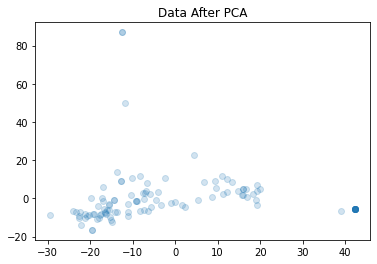

In [84]:
# plot PCA
x = []
y = []
for e in pca_features:
    x.append(round(e[0],4))
    y.append(round(e[1],4))
  
plt.title('Data After PCA')
plt.plot(x,y,'o',alpha=0.2)
plt.show()

In [43]:
# save just x,y as df csv with rest of info
# (add proposed country?) 
df = pd.DataFrame(list(zip(id_lst, date_lst, title_lst, x, y, body_lst)),
               columns =['id', 'date', 'title', 'x', 'y', 'body'])

# make copy of data frame (with untouched data)
df_all = df.copy()

# remove duplicates
df.drop_duplicates(subset=None, keep="first", inplace=True)
df.head(5)
print('dataframe length with duplicate rows:', len(df_all))
print('dataframe length without duplicate rows:', len(df))

dataframe length with duplicate rows: 111
dataframe length without duplicate rows: 94


In [58]:
summary_lst = []
#summary_prompt = '\n\n4th grader summary title for the UN resolution text above:\n'
#prefix = 'UNGA Resolution Text:'
#summary_prompt = '\n\nFourth grader one paragraph summary of UNGA resolution text above:\n'
summary_prompt = '\n\nTeacher Question: Provide a 1 paragraph summary of the UNGA resolution text above.\n\nFourth-grade Student Answer:'# This UNGA resolution'
for body, title in zip(df['body'], df['title']): # get new lists from dropped
    response = co.generate( 
    model='xlarge', 
    prompt= body + summary_prompt,
    max_tokens=256, 
    temperature=0.8, # lower temp? stop these weird additions? no sign offs, use \n
    frequency_penalty=0.9, 
    presence_penalty=0.5,
    end_sequences=['\n','--','=','__'])

    summary = response.generations[0].text
    summary_lst.append(summary)
    print('###################')
    print(title)
    #print(body)
    print(summary)

# do this later on after the doubles are dropped though
df['summary'] = summary_lst

###################
ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOODING EXPERIENCED IN RECENT MONTHS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
 The UN is worried about Bolivia's problems, so they passed a resolution saying that they are going to help Bolivia with their natural disasters. The US voted yes on the resolution because we know how important it is to get help after a bad storm or flood or something like that.
###################
THE DESTRUCTION OF RELICS AND MONUMENTS IN AFGHANISTAN : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
 This was passed by the UN General Assembly because they wanted to keep people safe from violence and terrorism but not destroy anyone's culture in the process. It is very important to have this world peace for everyone and no one country should ruin it! The sculpture may look ugly but it still has its own purpose just like us humans! Everyone should learn about other cultures because we can learn more things that we don't know!
###################

In [60]:
# put all in data frame and save as .csv
df.to_csv('unga_embeddings_pca.csv', index=False)

https://docs.cohere.ai/docs/semantic-search

In [61]:
# semantic search on this text

query = "What is the UN doing on Terrorism and Nuclear Weapons?"

# Get the query's embedding
query_embed = co.embed(texts=[query]).embeddings
query_embed = np.array(query_embed)
#print(query_embed.shape)

# get most similar embeddings
similarity_lst = []
for x in X:
    x = x.reshape((1, 4096))
    # (4096,) but want (1, 4096)
    similarity = cosine_similarity(x, query_embed)
    similarity_lst.append(similarity[0][0]) 

# make dataframe and list on max similarity_lst
df_all['similarity'] = similarity_lst

# remove duplicates
#df_all.drop_duplicates(subset=None, keep="first", inplace=True)
#df_all.head(5)
#print(len(df))

df_sorted = df_all.sort_values(by=['similarity'], ascending=True) 
#pd.set_option('display.expand_frame_repr', False)
df_sorted.head(5)

,id,date,title,x,y,body,similarity
30,A/RES/56/4_en,2001-11-13T00:00:00Z,OBSERVANCE OF THE INTERNATIONAL DAY FOR PREVEN...,-11.8542,50.0685,\n\n,0.034078
28,A/RES/56/5_en,2001-07-31T00:00:00Z,INTERNATIONAL DECADE FOR A CULTURE OF PEACE AN...,-12.4510,86.9555,\n\n\n\n\n\n\n\n,0.154481
93,A/RES/56/298_en,2001-08-03T00:00:00Z,FINANCING OF THE UNITED NATIONS MISSION FOR TH...,-12.4510,86.9555,\n\n\n\n\n\n\n\n,0.154481
99,A/RES/56/509_en,2002-07-10T00:00:00Z,"AMENDMENTS TO RULES 30, 31 AND 99 OF THE RULES...",-19.8307,-0.0251,\n United Nations A/RES/56/509 \n\n \n\nGenera...,0.270856
13,A/RES/S-25/1_en,2001-06-14T00:00:00Z,CREDENTIALS OF REPRESENTATIVES TO THE 25TH SPE...,-17.3962,-8.3611,\nUnited Nations A/RES/S-25/1\n\nGeneral Assem...,0.330469


In [62]:
print('Most relevent resolutions: \n###############################')
i = 0
for t in df_sorted['title']:
    if i<5:
        i+=1
        print('\n', i,')')
        print(t)
    else:
        break

Most relevent resolutions: 
###############################

 1 )
OBSERVANCE OF THE INTERNATIONAL DAY FOR PREVENTING THE EXPLOITATION OF THE ENVIRONMENT IN WAR AND ARMED CONFLICT : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY

 2 )
INTERNATIONAL DECADE FOR A CULTURE OF PEACE AND NON-VIOLENCE FOR THE CHILDREN OF THE WORLD, 2001-2010 : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY

 3 )
FINANCING OF THE UNITED NATIONS MISSION FOR THE REFERENDUM IN WESTERN SAHARA : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY

 4 )
AMENDMENTS TO RULES 30, 31 AND 99 OF THE RULES OF PROCEDURE OF THE GENERAL ASSEMBLY : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY

 5 )
CREDENTIALS OF REPRESENTATIVES TO THE 25TH SPECIAL SESSION OF THE GENERAL ASSEMBLY : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY


In [63]:
# put all in data frame and save as .csv
df_sorted.to_csv('unga_embeddings_pca_sorted.csv', index=False)

I just pull out the relevant resolutions for now but in future this can be extended to put in the prompt and answer questions (project I did before for different thing)

In [ ]:
# topic modelling

### Extentions:
- https://txt.cohere.ai/multilingual/
- Search
- Similar to paper clustering but possibly more convoluted
- Seocond grade summary of specific resoltions